# Лабораторная работа 2. Ассоциативные правила

## Описание работы

**Цель работы:** исследование методов анализа ассоциативных правил.

**Постановка задачи:**

В файле "ass_rules.pdf" находится программный код для выполнения данной работы. Провести исследование методов анализа ассоциативных правил на датасете с Kaggle:

1. Загрузить датасет из репозитория (например, kaggle.com или аналогичных платформ). Данные должны представлять собой информацию о купленных вместе товарах .

2. Привести описание данных из датасета: график вывода длин транзакций, список уникальных товаров и др. 

3. Алгоритм Apriori: выполнить анализ ассоциативных правил при помощи алгоритма Apriori с изначальными условиями в соответствии с вариантом задания. Проанализировать полученные результаты, выделив полезные и тривиальные правила, и оценив значение достоверности, лифта правил. Провести оценку влияния параметров алгоритма на получаемые правила (на количество правил и метрики).

4. Алгоритм FPG: провести анализ правил, используя алгоритм FPG. В отчете привести правила, получившиеся в результате использования данного алгоритма.

5. Алгоритмически определить минимальные значения поддержки для составления правил из 1, 2, и т.д. объектов в одном из алгоритмов.

6. Последовательно меняя параметры (значения поддержки и достоверности) одного из алгоритмов получить наборы ассоциативных правил. Сделать выводы на основе проведенных экспериментов.

7. Проанализировать получающийся в результате работы программы граф. Объяснить, какую информацию можно из него извлечь.

8. Предложить и реализовать свой способ визуализации ассоциативных правил и метрик.

## Ход работы

**О датасете:** Этот набор данных, содержит информацию обо всех транзакциях, произошедших в период с 01.12.2010 по 09.12.2011 в британской зарегистрированной интернет-компании, не имеющей физического магазина. Компания в основном продаёт уникальные подарки на все случаи жизни. Многие клиенты компании являются оптовыми покупателями.

### 1 Загрузка данных

Загрзим данные и выведим первые пять элементов


In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('retail_dataset.csv')

data.head()

,0,1,2,3,4,5,6
0,Bread,Wine,Eggs,Meat,Cheese,Pencil,Diaper
1,Bread,Cheese,Meat,Diaper,Wine,Milk,Pencil
2,Cheese,Meat,Eggs,Milk,Wine,NaN,NaN
3,Cheese,Meat,Eggs,Milk,Wine,NaN,NaN
4,Meat,Pencil,Wine,NaN,NaN,NaN,NaN


Каждая строчка состоит из списка купленных товаров в одной транзакции.

### 2 Анализ данных

Построим гистограмму, которая покажет, как распределены длины транзакций в датасете.

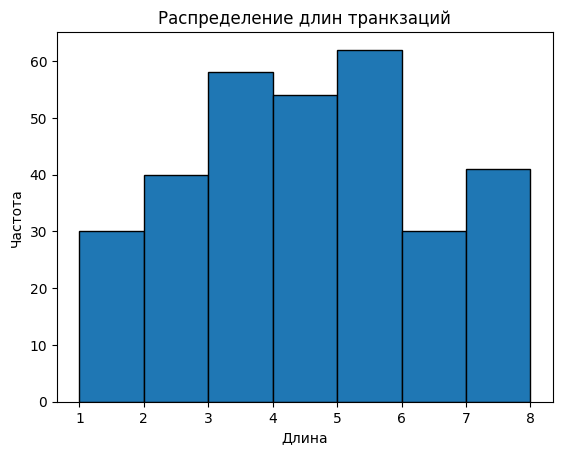

1    30
2    40
3    58
4    54
5    62
6    30
7    41
Name: count, dtype: int64


In [165]:
transaction_length = data.notna().sum(axis=1)

plt.hist(transaction_length, bins=range(1, max(transaction_length)+2), edgecolor='black')

plt.title('Распределение длин транкзаций')
plt.xlabel('Длина')
plt.ylabel('Частота')
plt.show()

print(transaction_length.value_counts().sort_index())

Гистограмма распределения длины транзакций показывает, что большинство покупок являются средними по объему — типичный чек содержит от 3 до 5 товаров, что составляет основную массу транзакций в датасете. При этом крупные покупки (6-7 товаров) и мелкие (1-2 товара) встречаются значительно реже.

Далее избавимся от NaN значений

In [166]:
np_data = data.to_numpy()
np_data = [[elem for elem in row if isinstance(elem,str)] for row in np_data]

Перед применением алгоритмов преобразуем данные в бинарный формат (one-hot encoding), где каждая транзакция представлена как вектор из 0 и 1.

In [167]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()

te_data = te.fit_transform(np_data)

data_encoder = pd.DataFrame(te_data, columns=te.columns_)

data_encoder.head()

,Bagel,Bread,Cheese,Diaper,Eggs,Meat,Milk,Pencil,Wine
0,False,True,True,True,True,True,False,True,True
1,False,True,True,True,False,True,True,True,True
2,False,False,True,False,True,True,True,False,True
3,False,False,True,False,True,True,True,False,True
4,False,False,False,False,False,True,False,True,True


Мы преобразовали данные в бинарный вид для использования алгоритмов, т.к. нам не важно, встречается ли один товар в транзакции несколько раз. Нам важно лишь знать, есть ли он вообще. Так, например, в первой транзакции из наших уникальных товаров есть только Bread, Cheese, Diaper, Eggs, Meat, Pencil и Wine, отсутствуют Bagel и Milk.

Выведим уникальные значения (товары):

Bread     159
Milk      158
Cheese    158
Meat      150
Wine      138
Eggs      138
Bagel     134
Diaper    128
Pencil    114
dtype: int64


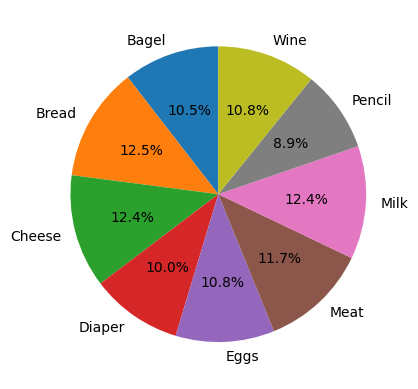

In [168]:
print(data_encoder.sum().sort_values(ascending=False))
plt.pie(data_encoder.sum(), labels=data_encoder.columns, autopct='%1.1f%%', startangle=90)
plt.show()

Был получен список самых популярных товаров, отсортированный по убыванию частоты встречаемости. Лидерами продаж являются Bread (`159` упоминаний), Milk и Cheese (по `158` упоминаний), Meat (`150`), Wine и Eggs (по `138`). Замыкают список Begel (`134`), Diaper (`128`) и Pensil (`114`). Такое распределение демонстрирует преобладание продуктов питания в потребительской корзине, при этом товары непродовольственной категории пользуются стабильным, но менее массовым спросом.

### 3 Алоритм Apriori
#### 3.1 Анализ ассоциативных правил с изначальными условиями в соответствии с вариантом задания.

Начальные параметры: поддержка `0.15` и достоверность `0.4`. 


In [169]:
from mlxtend.frequent_patterns import apriori, association_rules

frequent_itemsets = apriori(data_encoder, min_support=0.15, use_colnames=True)

frequent_itemsets.head()

,support,itemsets
0,0.425397,(Bagel)
1,0.504762,(Bread)
2,0.501587,(Cheese)
3,0.406349,(Diaper)
4,0.438095,(Eggs)


Мы получили frequent_itemsets с минимальной поддержкой 15%  и применили функцию association_rules с минимальным порогом уверенности 40% для генерации ассоциативных правил.

In [170]:
rules = association_rules(frequent_itemsets, min_threshold=0.4)
print(f'Количество правил: {len(rules)}')

Количество правил: 99


Перед тем как смотреть на полученные правила, следует вывести популярные позиции продуктов, для того,  чтобы избежать тривиальных правил

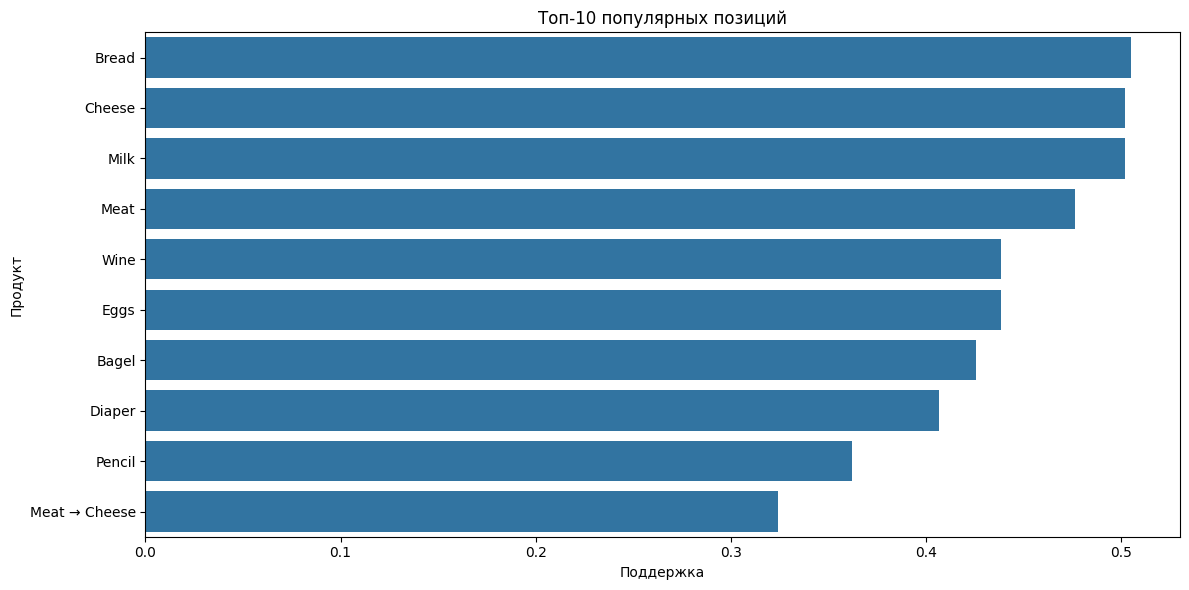

     support       itemsets
1   0.504762          Bread
2   0.501587         Cheese
6   0.501587           Milk
5   0.476190           Meat
8   0.438095           Wine
4   0.438095           Eggs
0   0.425397          Bagel
3   0.406349         Diaper
7   0.361905         Pencil
26  0.323810  Meat → Cheese


In [171]:
frequent_itemsets['itemsets'] = frequent_itemsets['itemsets'].apply(lambda x: ' → '.join(list(x)))
top_product = frequent_itemsets.sort_values(by='support', ascending=False).head(10)
plt.figure(figsize=(12,6))
sns.barplot(x='support', y='itemsets', data=top_product)
plt.title('Топ-10 популярных позиций')
plt.xlabel('Поддержка')
plt.ylabel('Продукт')
plt.tight_layout()
plt.show()
print(top_product)

Как видно из данных, наиболее популярные одиночные товары — это Bread (`50.5%`), Cheese (`50.2%`) и Milk (`50.2%`). Среди пар товаров выделяется набор `Meat → Cheese` с поддержкой `32.4%`, что указывает на их частую совместную покупку.

Теперь можем вывести полученные правила

In [172]:
col_name = ['antecedents', 'consequents', 'support', 'confidence', 'lift']
print(rules[col_name].sort_values(by='lift', ascending=False).to_string())

             antecedents     consequents   support  confidence      lift
98        (Eggs, Cheese)    (Milk, Meat)  0.152381    0.510638  2.088975
93          (Milk, Meat)  (Eggs, Cheese)  0.152381    0.623377  2.088975
94          (Milk, Eggs)  (Meat, Cheese)  0.152381    0.623377  1.925134
97        (Meat, Cheese)    (Milk, Eggs)  0.152381    0.470588  1.925134
95        (Milk, Cheese)    (Meat, Eggs)  0.152381    0.500000  1.875000
96          (Meat, Eggs)  (Milk, Cheese)  0.152381    0.571429  1.875000
90  (Milk, Meat, Cheese)          (Eggs)  0.152381    0.750000  1.711957
89    (Milk, Meat, Eggs)        (Cheese)  0.152381    0.857143  1.708861
88                (Eggs)    (Milk, Meat)  0.177778    0.405797  1.660079
85          (Milk, Meat)          (Eggs)  0.177778    0.727273  1.660079
73          (Milk, Meat)        (Cheese)  0.203175    0.831169  1.657077
78              (Cheese)    (Milk, Meat)  0.203175    0.405063  1.657077
91  (Milk, Eggs, Cheese)          (Meat)  0.152381 

Мы получили 99 правил с начальными параметрами. Чтобы выделить полезные и тривиальные правила, исключим правила, где `lift <= 1.2` и `confidence <=0.6`

In [173]:
rules[(rules['lift'] > 1.2) & (rules['confidence'] > 0.6)][col_name]

,antecedents,consequents,support,confidence,lift
1,(Bagel),(Bread),0.279365,0.656716,1.301042
24,(Eggs),(Cheese),0.298413,0.681159,1.358008
26,(Meat),(Cheese),0.323810,0.680000,1.355696
27,(Cheese),(Meat),0.323810,0.645570,1.355696
28,(Milk),(Cheese),0.304762,0.607595,1.211344
29,(Cheese),(Milk),0.304762,0.607595,1.211344
31,(Wine),(Cheese),0.269841,0.615942,1.227986
40,(Eggs),(Meat),0.266667,0.608696,1.278261
56,"(Milk, Bread)",(Bagel),0.171429,0.613636,1.442503
57,"(Milk, Bagel)",(Bread),0.171429,0.760563,1.506777


Полезными можно выделить следующие правила:
1. `Eggs → Cheese` - при покупке яиц в 68% случаев добавляют сыр

1. `Meat → Cheese` - покупатели мяса в 68% случаев берут сыр

1. `Cheese → Milk` - к сыру в 61% случаев добавляют молоко

1. `Wine → Cheese` - к вину в 62% случаев берут сыр (классическая гастрономическая пара)

1. `Diaper → Wine` - при покупке подгузников в 58% случаев добавляют вино ("эффект пива и подгузников")

1. `Eggs, Meat → Cheese` - при совместной покупке яиц и мяса в 81% случаев берут сыр

1. `Milk, Meat → Cheese, Eggs` - комплексный набор с максимальным лифтом 2.09

1. `Pencil → Wine` - неочевидная связь канцтоваров и алкоголя (55% случаев). Правило не так легко объяснить, возможно, вино покупают в комплекте с карандашами, например, чтобы работать.

1. `Bagel, Milk → Bread` - взаимодополняющие хлебобулочные товары (76% случаев)

#### 3.2 Изменение параметров алгоритма

Увеличим значение поддержки до `0.2` и достоверности до `0.5`:

In [174]:
frequent_itemsets = apriori(data_encoder, min_support=0.2, use_colnames = True)
rules = association_rules(frequent_itemsets,min_threshold=0.5)
print(f'Количество правил: {len(rules)}')
rules[col_name]

Количество правил: 35


,antecedents,consequents,support,confidence,lift
0,(Bread),(Bagel),0.279365,0.553459,1.301042
1,(Bagel),(Bread),0.279365,0.656716,1.301042
2,(Bagel),(Milk),0.225397,0.529851,1.056348
3,(Diaper),(Bread),0.231746,0.570312,1.129864
4,(Milk),(Bread),0.279365,0.556962,1.103415
5,(Bread),(Milk),0.279365,0.553459,1.103415
6,(Pencil),(Bread),0.200000,0.552632,1.094836
7,(Wine),(Bread),0.244444,0.557971,1.105414
8,(Eggs),(Cheese),0.298413,0.681159,1.358008
9,(Cheese),(Eggs),0.298413,0.594937,1.358008


Изменение параметров алгоритма Apriori закономерно влияет на формирование ассоциативных правил. При повышении минимальной поддержки с `0.15` до `0.2` и достоверности с `0.4` до `0.5` количество сгенерированных правил сократилось со `99` до `35`. Это объясняется отсечением менее значимых зависимостей, что позволило сохранить только наиболее устойчивые товарные связи.

При этом средние показатели достоверности и лифта увеличились, подтверждая возросшее качество оставшихся правил. Например, правило `Eggs, Meat → Cheese` с достоверностью 0.81 и лифтом 1.61 демонстрирует статистически значимую взаимосвязь. В то же время такие правила, как `Bread → Bagel` или `Milk → Bread`, с лифтом около 1.1–1.3 отражают скорее общую популярность товаров, чем их взаимное влияние.

Попробуем увеличить значение достоверности до `0.6`:

In [175]:
frequent_itemsets = apriori(data_encoder, min_support=0.2, use_colnames = True)
rules = association_rules(frequent_itemsets,min_threshold=0.6)
print(f'Количество правил: {len(rules)}')
rules[col_name]

Количество правил: 14

,antecedents,consequents,support,confidence,lift
0,(Bagel),(Bread),0.279365,0.656716,1.301042
1,(Eggs),(Cheese),0.298413,0.681159,1.358008
2,(Meat),(Cheese),0.323810,0.680000,1.355696
3,(Cheese),(Meat),0.323810,0.645570,1.355696
4,(Milk),(Cheese),0.304762,0.607595,1.211344
5,(Cheese),(Milk),0.304762,0.607595,1.211344
6,(Wine),(Cheese),0.269841,0.615942,1.227986
7,(Eggs),(Meat),0.266667,0.608696,1.278261
8,"(Meat, Eggs)",(Cheese),0.215873,0.809524,1.613924
9,"(Meat, Cheese)",(Eggs),0.215873,0.666667,1.521739


Было получено 14 ассоциативных правил, при этом количество тривиальных правил значительно сократилось. Можно заметить, что теперь почти половина правил состоят из 2 объектов, на которые теперь проще обратить внимание на более интересные правила.

Наиболее значимым правилом является `Milk, Meat → Cheese` с показателями достоверности `0.83` и лифта `1.66`, что свидетельствует о сильной взаимосвязи этих продуктов. Данная зависимость имеет практическую ценность, поскольку отражает типичное потребительское поведение при формировании комплекта продуктов для приготовления различных блюд, где сыр выступает естественным дополнением к мясу и молоку.


Теперь попробуес добиться оптимального числа правил. Для этого уменьшим поддержку до `0.15`, а достоверность увеличим до `0.7`:

In [176]:
frequent_itemsets = apriori(data_encoder, min_support=0.15, use_colnames = True)
rules = association_rules(frequent_itemsets,min_threshold=0.7)
print(f'Количество правил: {len(rules)}')
rules[col_name]

Количество правил: 12


,antecedents,consequents,support,confidence,lift
0,"(Milk, Bagel)",(Bread),0.171429,0.760563,1.506777
1,"(Meat, Eggs)",(Cheese),0.215873,0.809524,1.613924
2,"(Eggs, Cheese)",(Meat),0.215873,0.723404,1.519149
3,"(Milk, Eggs)",(Cheese),0.196825,0.805195,1.605293
4,"(Milk, Meat)",(Cheese),0.203175,0.831169,1.657077
5,"(Milk, Wine)",(Cheese),0.161905,0.739130,1.473583
6,"(Milk, Meat)",(Eggs),0.177778,0.727273,1.660079
7,"(Milk, Eggs)",(Meat),0.177778,0.727273,1.527273
8,"(Milk, Meat, Eggs)",(Cheese),0.152381,0.857143,1.708861
9,"(Milk, Meat, Cheese)",(Eggs),0.152381,0.750000,1.711957


После увеличения порога достоверности до 0.7 и увеличении минимальной поддержки 0.15 количество выявленных правил уменьшилось до 12.

Наиболее выраженные правила наблюдаются между группами продуктов, которые логично сочетаются в покупательских корзинах. Например, покупка яиц, молока и мяса почти всегда сопровождается приобретением сыра, что подтверждается высокой достоверностью `0.86` и лифтом `1.71`. Аналогично, связь между молоком и мясом по отношению к сыру также остаётся устойчивой, с достоверностью `0.83` и лифтом `1.66`. Такие результаты показывают, что повышение порога достоверности позволяет выявить только наиболее надёжные и закономерные сочетания товаров.

#### 3.3 График достоверности и граф правил

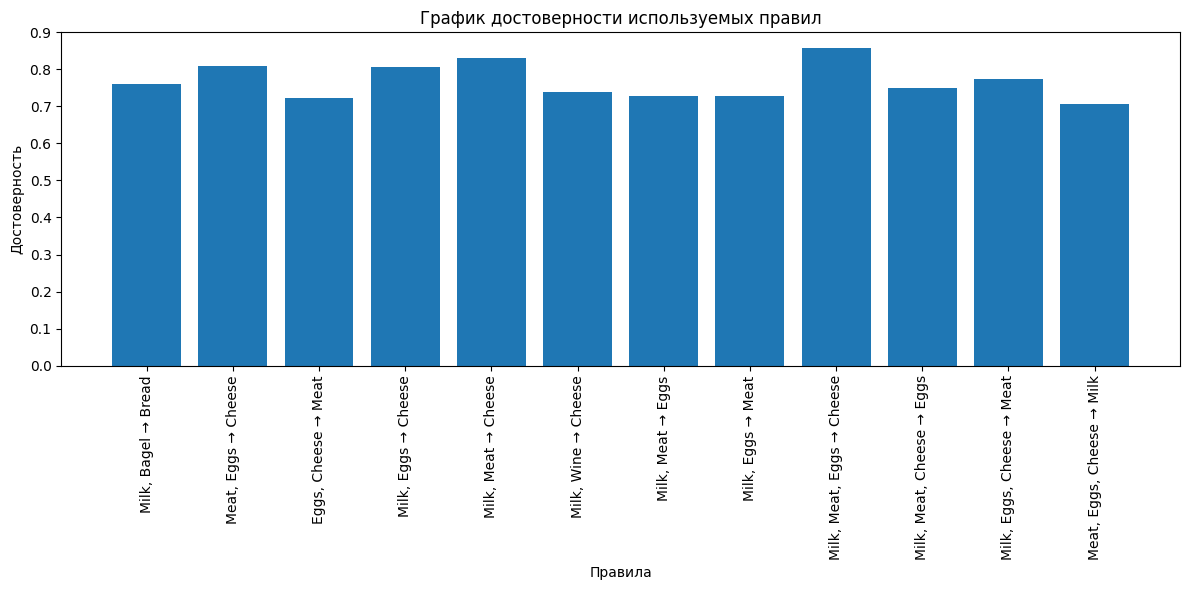

In [177]:
rules['antecedents'] =  rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))
products_1 = rules["antecedents"].tolist()
products_2 = rules["consequents"].tolist()
confidence = rules['confidence'].to_list()

rules_labels = [f"{products_1} → {products_2}" for products_1, products_2 in zip(products_1, products_2)]
plt.figure(figsize=(12, 6))
plt.bar(rules_labels, confidence)
plt.xlabel('Правила')
plt.ylabel('Достоверность')
plt.xticks(rotation=90)
plt.title('График достоверности используемых правил')
plt.tight_layout()
plt.show()

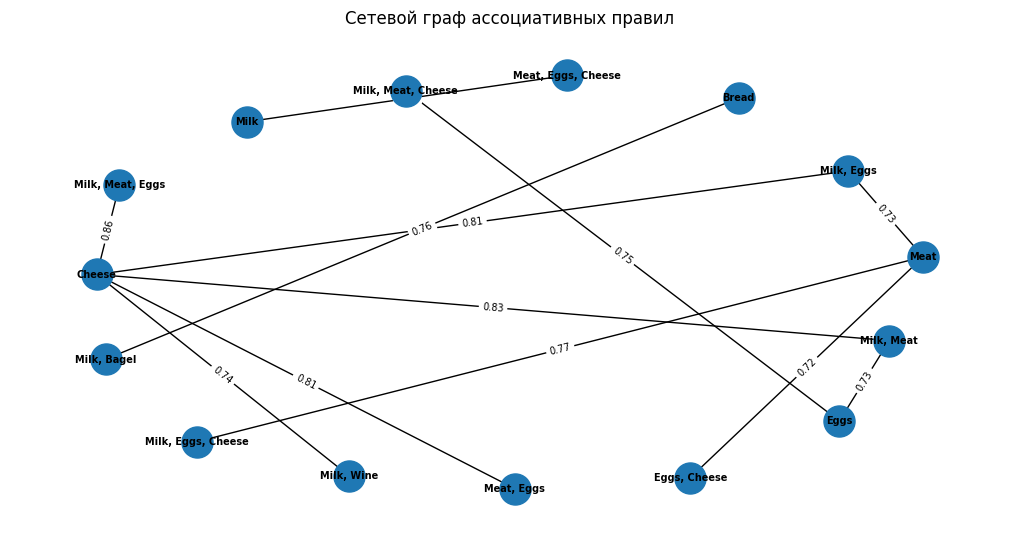

In [178]:
import networkx as nx
G = nx.Graph()
for product in rules["antecedents"]:
    G.add_node(product)
for product in rules["consequents"]:
    G.add_node(product)
for index, row in rules.iterrows():
    G.add_edge(row['antecedents'], row['consequents'], weight=round(row['confidence'],2))
pos = nx.spring_layout(G,k=8, iterations=100)
plt.figure(figsize=(10,5))
nx.draw(G, pos,  with_labels=True, node_size=500, font_size=7, font_weight='bold')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
plt.title('Сетевой граф ассоциативных правил')
plt.show()

#### 3.4 Визуализации ассоциативных правил и метрик

Также для визуализации правил можно использовать heatmap, где на осях x и y откладываюся antecedents и consequents, а цвет отражает показатель `confidence` или `lift`. Эти пары показывают связь.

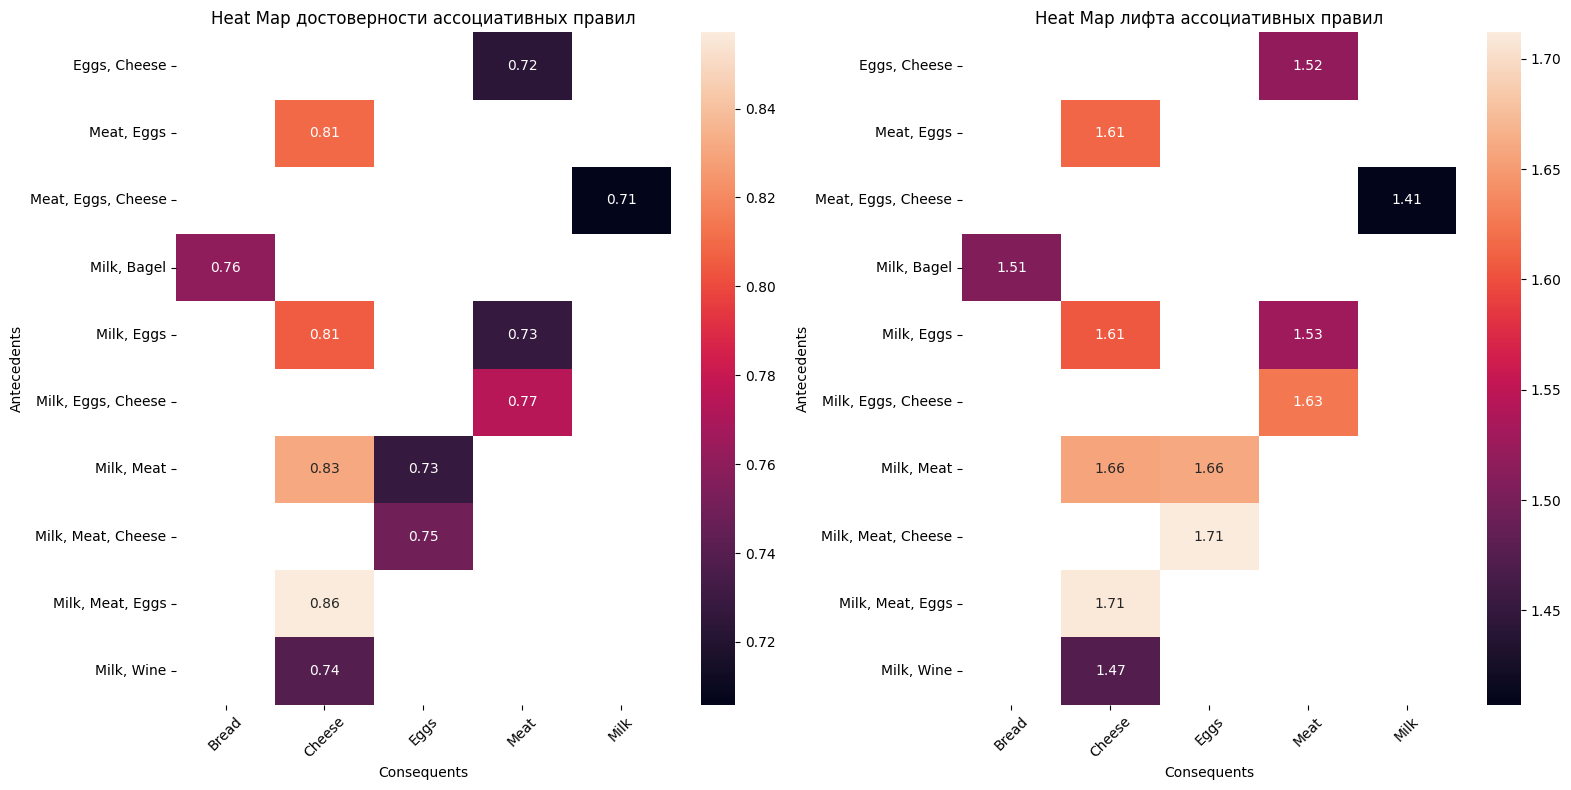

In [179]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))



heat_data_conf = rules.pivot(index='antecedents', columns='consequents', values='confidence')
sns.heatmap(heat_data_conf, annot=True, fmt=".2f", ax=axes[0])
axes[0].set_title('Heat Map достоверности ассоциативных правил')
axes[0].set_xlabel('Consequents')
axes[0].set_ylabel('Antecedents')
axes[0].tick_params(axis='x', rotation=45, labelrotation=45)


heat_data_lift = rules.pivot(index='antecedents', columns='consequents', values='lift')
sns.heatmap(heat_data_lift, annot=True, fmt=".2f", ax=axes[1])
axes[1].set_title('Heat Map лифта ассоциативных правил')
axes[1].set_xlabel('Consequents')
axes[1].set_ylabel('Antecedents')
axes[1].tick_params(axis='x', rotation=45, labelrotation=45)

plt.tight_layout()
plt.show()

Тепловая карта наглядно демонстрирует, для каких ассоциативных правил значения лифта самые высокие .

#### 3.5 Минимальные значения поддержки для составления правил из 1, 2 и т.д. объектов в одном из алгоритмов

Минимальные значения поддержки по длинам наборов:
length
1    0.361905
2    0.152381
3    0.063492
4    0.025397
5    0.012698
6    0.012698
7    0.012698
Name: support, dtype: float64


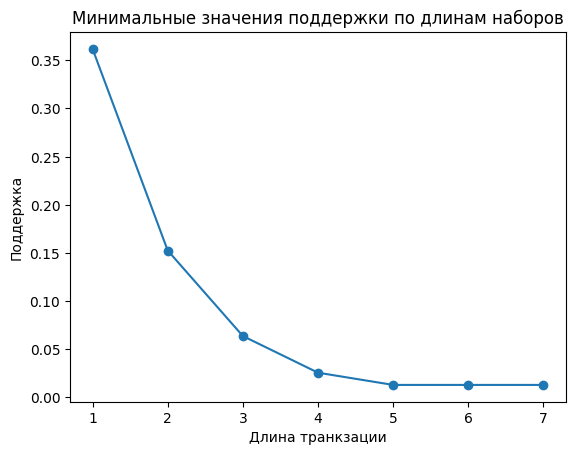

In [180]:
df1 = apriori(data_encoder, min_support=0.01, use_colnames = True)
df1['length'] = df1['itemsets'].apply(lambda x: len(x))
min_support_by_len = df1.groupby('length')['support'].min()

print("Минимальные значения поддержки по длинам наборов:")
print(min_support_by_len)

plt.plot(min_support_by_len.index, min_support_by_len.values, marker='o')
plt.ylabel('Поддержка')
plt.xlabel('Длина транкзации')
plt.title('Минимальные значения поддержки по длинам наборов')
plt.show()

Анализ минимальной поддержки по длинам наборов демонстрирует ожидаемое снижение частоты встречаемости с увеличением размера комбинаций: от `36%` для одиночных товаров до `15%` для пар, `6%` для троек и менее `3%` для более крупных наборов, что отражает естественное уменьшение вероятности совместного приобретения множества товаров в одной транзакции и соответствует реальным потребительским паттернам.

### 4 Алоритм FPG
#### 4.1 Анализ ассоциативных правил с изначальными условиями в соответствии с вариантом задания.

Начальные параметры: поддержка `0.15` и достоверность `0.4`. 

In [181]:
from mlxtend.frequent_patterns import fpgrowth

frequent_itemsets = fpgrowth(data_encoder, min_support=0.15, use_colnames=True)
rules = association_rules(frequent_itemsets, min_threshold=0.4)
print(f'Количество правил: {len(rules)}')


Количество правил: 99


Мы получили frequent_itemsets с минимальной поддержкой 15%  и применили функцию association_rules с минимальным порогом уверенности 40% для генерации ассоциативных правил.

Выведим полученные правила

In [182]:
col_name = ['antecedents', 'consequents', 'support', 'confidence', 'lift']
print(rules[col_name])

       antecedents    consequents   support  confidence      lift
0          (Bread)       (Cheese)  0.238095    0.471698  0.940411
1         (Cheese)        (Bread)  0.238095    0.474684  0.940411
2           (Meat)       (Cheese)  0.323810    0.680000  1.355696
3         (Cheese)         (Meat)  0.323810    0.645570  1.355696
4          (Bread)         (Meat)  0.206349    0.408805  0.858491
..             ...            ...       ...         ...       ...
94         (Bagel)         (Meat)  0.190476    0.447761  0.940299
95   (Milk, Bread)        (Bagel)  0.171429    0.613636  1.442503
96   (Milk, Bagel)        (Bread)  0.171429    0.760563  1.506777
97  (Bread, Bagel)         (Milk)  0.171429    0.613636  1.223389
98         (Bagel)  (Milk, Bread)  0.171429    0.402985  1.442503

[99 rows x 5 columns]


Мы получили столько же правил, как и в алгоритме Apriori - 99 штук. Можем выделить тривиальные правила, к которым отноосятся первые несколько: `Cheese -> Bread` с достоверностью `0.474684` и лифтом `0.940411`, `Cheese -> Meat`, `Bread -> Meat`, `Milk -> Meat`, т.к. они содержат товары-лидеры продаж. Так же у двух из правил значение лифта меньше 1, что говорит о том, что эти правила не применимы.

Выделим полезные правила:

1. `Eggs → Cheese` - при покупке яиц в 68% случаев добавляют сыр

1. `Meat → Cheese` - покупатели мяса в 68% случаев берут сыр

1. `Cheese → Milk` - к сыру в 61% случаев добавляют молоко

1. `Wine → Cheese` - к вину в 62% случаев берут сыр (классическая гастрономическая пара)

1. `Diaper → Wine` - при покупке подгузников в 58% случаев добавляют вино ("эффект пива и подгузников")

1. `Eggs, Meat → Cheese` - при совместной покупке яиц и мяса в 81% случаев берут сыр

1. `Milk, Meat → Cheese, Eggs` - комплексный набор с максимальным лифтом 2.09

1. `Pencil → Wine` - неочевидная связь канцтоваров и алкоголя (55% случаев). Правило не так легко объяснить, возможно, вино покупают в комплекте с карандашами, например, чтобы работать.

1. `Bagel, Milk → Bread` - взаимодополняющие хлебобулочные товары (76% случаев)

#### 4.2 Изменение параметров алгоритма

Увеличим значение поддержки до `0.16` и достоверности до `0.7`:


In [183]:
frequent_itemsets = fpgrowth(data_encoder, min_support=0.16, use_colnames = True)
rules = association_rules(frequent_itemsets,min_threshold=0.7)
print(f'Количество правил: {len(rules)}')
rules[col_name]

Количество правил: 8


,antecedents,consequents,support,confidence,lift
0,"(Milk, Meat)",(Cheese),0.203175,0.831169,1.657077
1,"(Milk, Wine)",(Cheese),0.161905,0.739130,1.473583
2,"(Meat, Eggs)",(Cheese),0.215873,0.809524,1.613924
3,"(Eggs, Cheese)",(Meat),0.215873,0.723404,1.519149
4,"(Milk, Eggs)",(Cheese),0.196825,0.805195,1.605293
5,"(Milk, Meat)",(Eggs),0.177778,0.727273,1.660079
6,"(Milk, Eggs)",(Meat),0.177778,0.727273,1.527273
7,"(Milk, Bagel)",(Bread),0.171429,0.760563,1.506777


С параметрами `min_support=0.16` и `min_confidence=0.7` получено 8 высококачественных правил, где выделяются два ключевых паттерна: сочетание `Meat, Milk → Cheese` с максимальной достоверностью `0.83` и связка `Meat, Milk → Eggs` с наибольшим лифтом `1.66`, что демонстрирует устойчивую взаимосвязь мясо-молочной продукции с сыром и яйцами и подтверждает формирование комплексных продуктовых наборов для готовки.

#### 4.3 График достоверности и граф правил

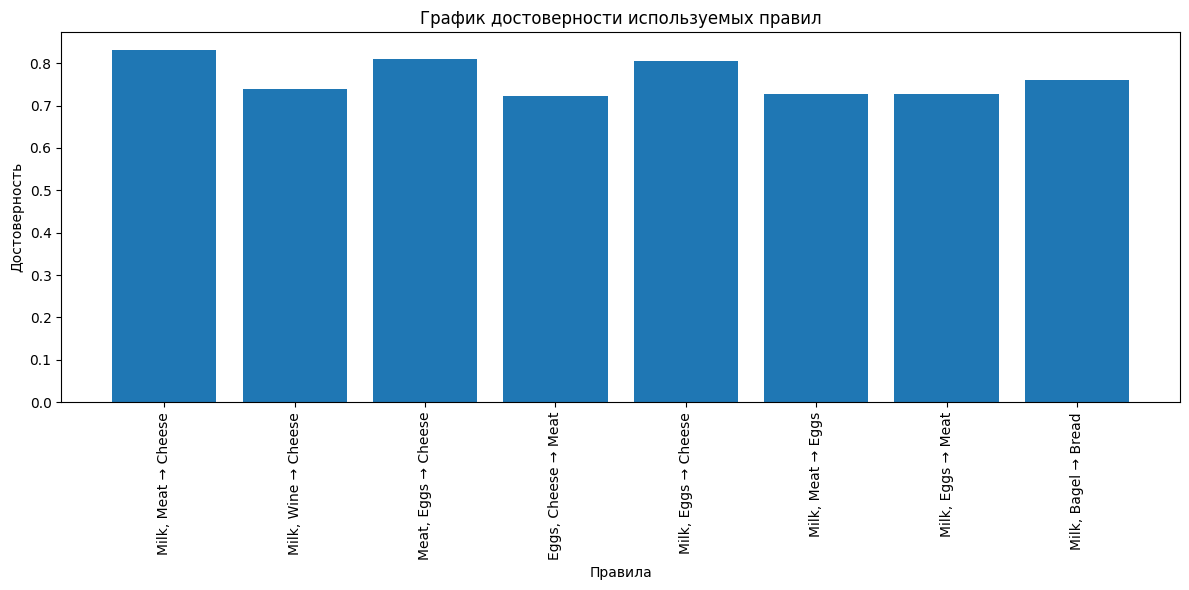

In [184]:
rules['antecedents'] =  rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))
products_1 = rules["antecedents"].tolist()
products_2 = rules["consequents"].tolist()
confidence = rules['confidence'].to_list()

rules_labels = [f"{products_1} → {products_2}" for products_1, products_2 in zip(products_1, products_2)]
plt.figure(figsize=(12, 6))
plt.bar(rules_labels, confidence)
plt.xlabel('Правила')
plt.ylabel('Достоверность')
plt.xticks(rotation=90)
plt.title('График достоверности используемых правил')
plt.tight_layout()
plt.show()

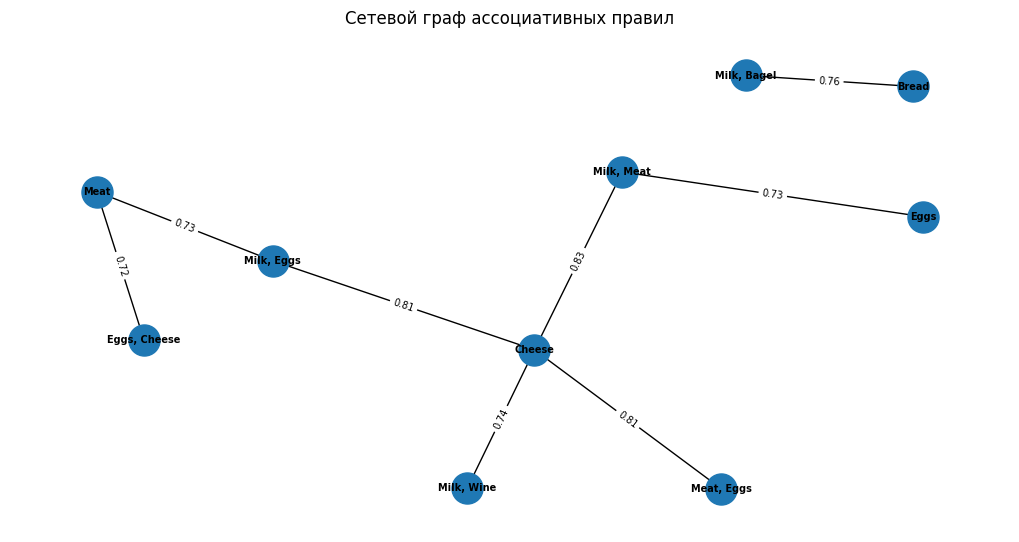

In [185]:
import networkx as nx
G = nx.Graph()
for product in rules["antecedents"]:
    G.add_node(product)
for product in rules["consequents"]:
    G.add_node(product)
for index, row in rules.iterrows():
    G.add_edge(row['antecedents'], row['consequents'], weight=round(row['confidence'],2))
pos = nx.spring_layout(G,k=1,iterations=50)
plt.figure(figsize=(10,5))
nx.draw(G, pos,  with_labels=True, node_size=500, font_size=7, font_weight='bold')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
plt.title('Сетевой граф ассоциативных правил')
plt.show()

#### 4.4 Визуализации ассоциативных правил и метрик

Также для визуализации правил можно использовать heatmap, где на осях x и y откладываюся antecedents и consequents, а цвет отражает показатель `confidence` или `lift`. Эти пары показывают связь.

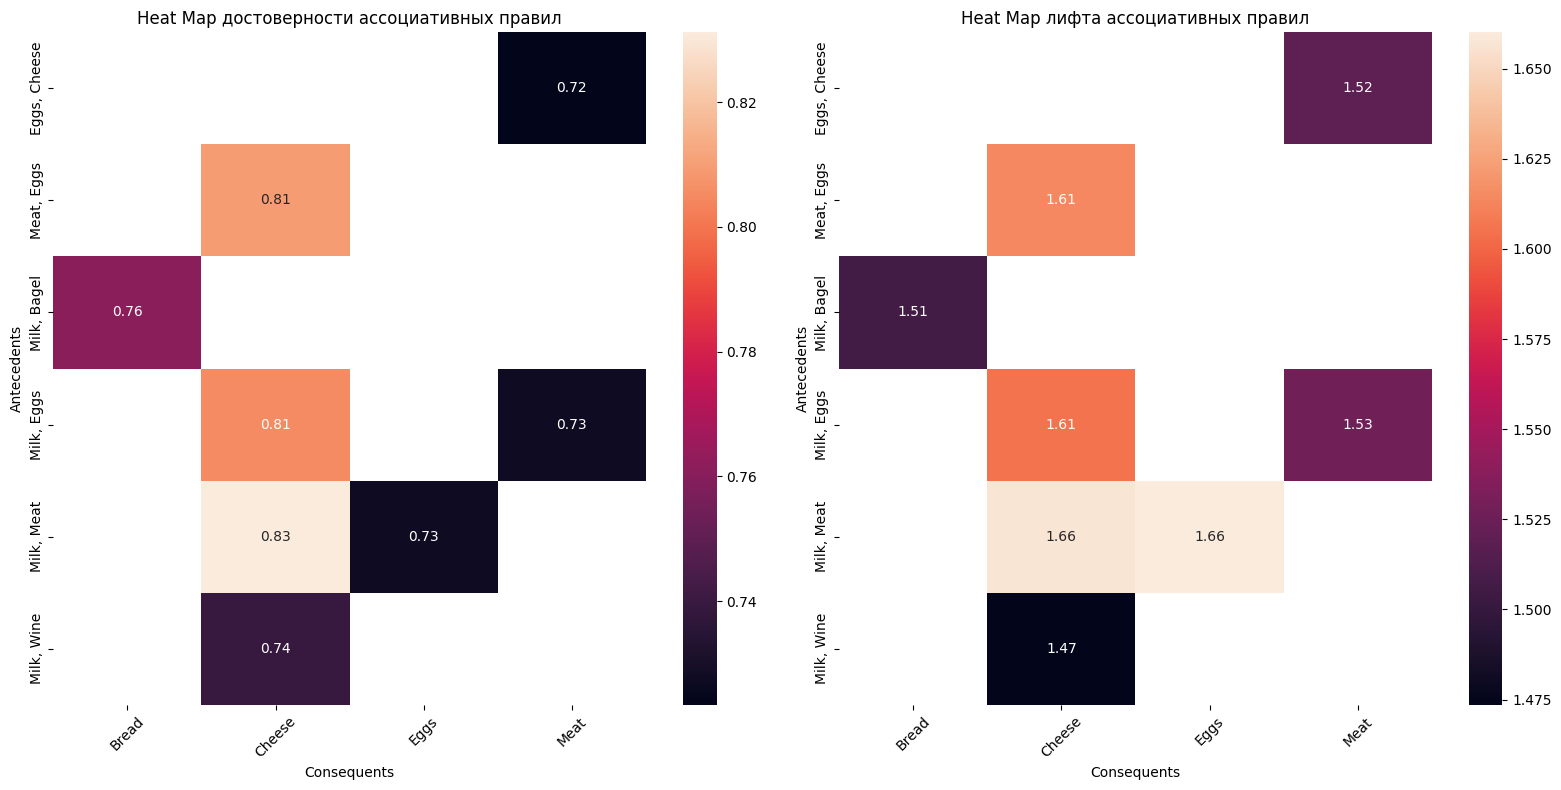

In [186]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))



heat_data_conf = rules.pivot(index='antecedents', columns='consequents', values='confidence')
sns.heatmap(heat_data_conf, annot=True, fmt=".2f", ax=axes[0])
axes[0].set_title('Heat Map достоверности ассоциативных правил')
axes[0].set_xlabel('Consequents')
axes[0].set_ylabel('Antecedents')
axes[0].tick_params(axis='x', rotation=45, labelrotation=45)


heat_data_lift = rules.pivot(index='antecedents', columns='consequents', values='lift')
sns.heatmap(heat_data_lift, annot=True, fmt=".2f", ax=axes[1])
axes[1].set_title('Heat Map лифта ассоциативных правил')
axes[1].set_xlabel('Consequents')
axes[1].set_ylabel('Antecedents')
axes[1].tick_params(axis='x', rotation=45, labelrotation=45)

plt.tight_layout()
plt.show()

Тепловая карта наглядно демонстрирует, для каких ассоциативных правил значения лифта самые высокие .

#### 4.5 Минимальные значения поддержки для составления правил из 1, 2 и т.д. объектов в одном из алгоритмов

Минимальные значения поддержки по длинам наборов:
length
1    0.361905
2    0.152381
3    0.063492
4    0.025397
5    0.012698
6    0.012698
7    0.012698
Name: support, dtype: float64


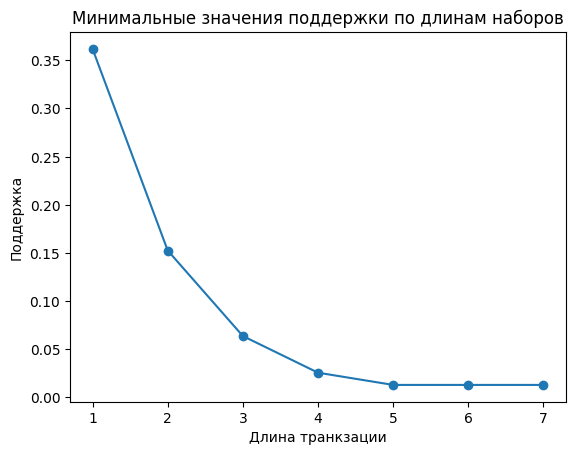

In [187]:
df1 = fpgrowth(data_encoder, min_support=0.01, use_colnames = True)
df1['length'] = df1['itemsets'].apply(lambda x: len(x))
min_support_by_len = df1.groupby('length')['support'].min()

print("Минимальные значения поддержки по длинам наборов:")
print(min_support_by_len)

plt.plot(min_support_by_len.index, min_support_by_len.values, marker='o')
plt.ylabel('Поддержка')
plt.xlabel('Длина транкзации')
plt.title('Минимальные значения поддержки по длинам наборов')
plt.show()

Анализ минимальной поддержки по длинам наборов демонстрирует ожидаемое снижение частоты встречаемости с увеличением размера комбинаций: от `36%` для одиночных товаров до `15%` для пар, `6%` для троек и менее `3%` для более крупных наборов, что отражает естественное уменьшение вероятности совместного приобретения множества товаров в одной транзакции и соответствует реальным потребительским паттернам.

### Вывод

В ходе исследования был выполнен сравнительный анализ ассоциативных правил с применением алгоритмов Apriori и FP-Growth. Подбор различных значений поддержки и достоверности позволил определить оптимальные параметры (`support=0.15`, `confidence=0.7`), при которых формируется сбалансированное количество правил с высокими показателями достоверности и лифта, свидетельствующими о статистически значимых взаимосвязях.

Наиболее выраженные паттерны выявлены между товарными категориями `молоко-мясо-яйца-сыр`, что соответствует реальным поведенческим моделям покупателей. Повышение пороговых значений подтвердило ожидаемую динамику: сокращение количества правил при одновременном росте их качества и практической ценности.

Алгоритмы Apriori и FP-Growth продемонстрировали идентичные результаты, что объясняется их общей теоретической основой поиска частых наборов, несмотря на различия в вычислительных подходах: поэтапное наращивание кандидатов в Apriori против сжатого представления данных в FP-Growth. Совпадение результатов верифицирует корректность методики и надежность выявленных закономерностей.